In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [5]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [6]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [7]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

max_date

('2017-08-23')

In [12]:
# Perform a query to retrieve the date and precipitation scores
one_year = dt.date(2017,8,23) - dt.timedelta(days=365)

one_year

datetime.date(2016, 8, 23)

In [13]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year).\
    order_by(Measurement.date).all()

In [14]:
# Sort the dataframe by date
precipitation_df = pd.DataFrame(precipitation_data, columns=["date","precipitation"])
precipitation_df.set_index("date", inplace=True,)
precipitation_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,0.15
2016-08-23,0.05
2016-08-23,NaN
2016-08-23,0.02


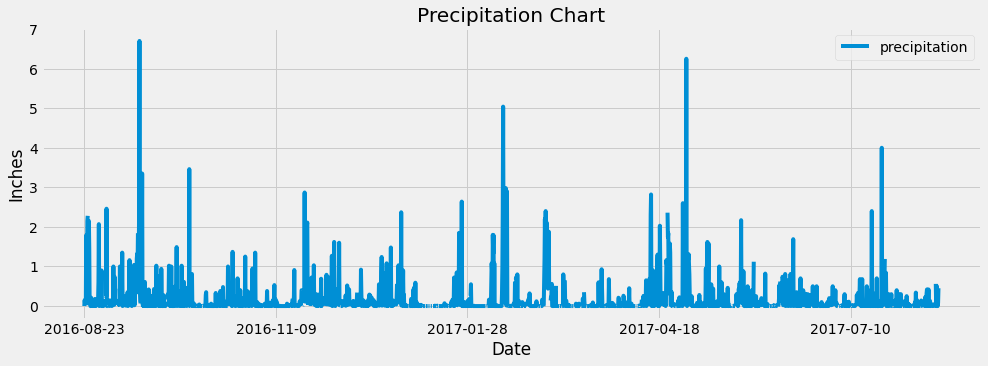

In [15]:
# Use Pandas Plotting with Matplotlib to plot the data
precipitation_df.plot(title='Precipitation Chart', figsize=(15,5), xlabel='Date', ylabel='Inches')
plt.show()

In [16]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_df.describe()


,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [17]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Station).count()
print(f'There are {station_count} stations')

There are 9 stations


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
# If you in your session.query(Measurement.station, func.count(Measurement.station))
# .group_by on Measurement.station and also .order_by(func.count(Measurement.station) and sort in desc order

most_active_stations = session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).\
                        order_by(func.count(Measurement.station).desc()).all()

most_active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
#.filter on Measurment.station using the station id that appeared at the top of the previous answer
# the session.query(func.min(Measurement.tobs), func.max(Measurment.tobs), func.avg(Measurment.tobs))

sel = [Measurement.station,
       func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)]

temperature_results = session.query(*sel).filter(Measurement.station == 'USC00519281').all()

temp_results_df=pd.DataFrame(temperature_results, columns=['station','min_temp', 'max_temp', 'avg_temp'])
temp_results_df.set_index('station', inplace=True)
temp_results_df


,min_temp,max_temp,avg_temp
station,,,
USC00519281,54.0,85.0,71.663781


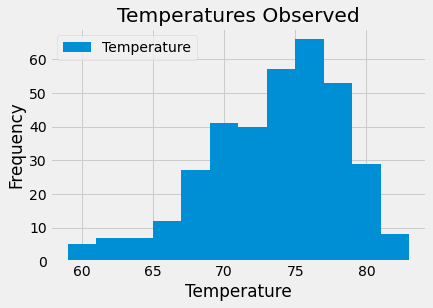

In [20]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

tobs_data = session.query(Measurement.tobs).\
            filter(Measurement.station == 'USC00519281').\
            filter(Measurement.date >= one_year)

#put the results into a dataframe, i.e. use pd.DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["Temperature"])

# #df.plot.hist(bins=12)
tobs_df.plot.hist(bins=12, title='Temperatures Observed')
plt.xlabel('Temperature')
plt.show()


## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [29]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date = '2017-08-09'
end_date = '2017-08-23'
calulate_temps = calc_temps(start_date, end_date)
temps_df = pd.DataFrame(calulate_temps, columns=['tmin', 'tavg', 'tmax'])
temps_df.head()

,tmin,tavg,tmax
0,70.0,78.644068,85.0


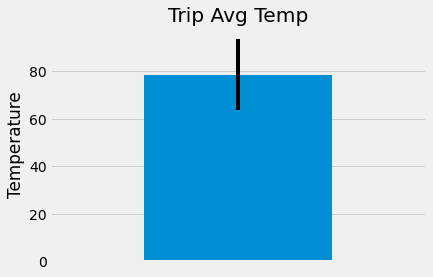

In [30]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

ax = temps_df['tavg'].plot.bar(yerr=(temps_df['tmax']-temps_df['tmin']), title='Trip Avg Temp', ylabel = 'Temperature')
ax.axes.get_xaxis().set_visible(False)
plt.show()


In [31]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
sel = [Measurement.station, 
       func.sum(Measurement.prcp),
       Station.name,
       Station.latitude,
       Station.longitude,
       Station.elevation
      ]

station_totals = session.query(*sel).\
        filter(Measurement.station == Station.station, func.strftime(Measurement.date) >= start_date, func.strftime(Measurement.date) <= end_date) \
        .group_by(Measurement.station) \
        .order_by(func.sum(Measurement.prcp).desc()).all()

station_totals


[('USC00516128',
  3.1500000000000004,
  'MANOA LYON ARBO 785.2, HI US',
  21.3331,
  -157.8025,
  152.4),
 ('USC00519281',
  0.51,
  'WAIHEE 837.5, HI US',
  21.45167,
  -157.84888999999998,
  32.9),
 ('USC00519523',
  0.34,
  'WAIMANALO EXPERIMENTAL FARM, HI US',
  21.33556,
  -157.71139,
  19.5),
 ('USC00514830',
  0.04,
  'KUALOA RANCH HEADQUARTERS 886.9, HI US',
  21.5213,
  -157.8374,
  7.0),
 ('USC00519397', 0.02, 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0)]

In [25]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [33]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-09'
end_date = '2017-08-23'

# Use the start and end date to create a range of dates
date_range = pd.date_range(start_date, end_date).tolist()

# Stip off the year and save a list of %m-%d strings
trip_dates = []
for date in date_range:
    trip_dates.append(date.strftime('%m-%d'))
    
# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for value in trip_dates:
    normals.append(daily_normals(value)[0])

normals

[(69.0, 75.98039215686275, 81.0),
 (65.0, 76.42, 83.0),
 (67.0, 75.98113207547169, 82.0),
 (67.0, 76.52727272727273, 83.0),
 (71.0, 76.98245614035088, 84.0),
 (71.0, 76.77777777777777, 82.0),
 (69.0, 76.47169811320755, 83.0),
 (69.0, 76.08, 83.0),
 (69.0, 76.125, 83.0),
 (70.0, 76.92307692307692, 84.0),
 (69.0, 75.94642857142857, 85.0),
 (68.0, 76.45283018867924, 82.0),
 (67.0, 76.4, 83.0),
 (69.0, 76.47169811320755, 84.0),
 (67.0, 76.6923076923077, 87.0)]

In [34]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['min_temp','avg_temp','max_temp'],index=trip_dates)
normals_df.index.name='date'
normals_df


,min_temp,avg_temp,max_temp
date,,,
08-09,69.0,75.980392,81.0
08-10,65.0,76.420000,83.0
08-11,67.0,75.981132,82.0
08-12,67.0,76.527273,83.0
08-13,71.0,76.982456,84.0
08-14,71.0,76.777778,82.0
08-15,69.0,76.471698,83.0
08-16,69.0,76.080000,83.0
08-17,69.0,76.125000,83.0


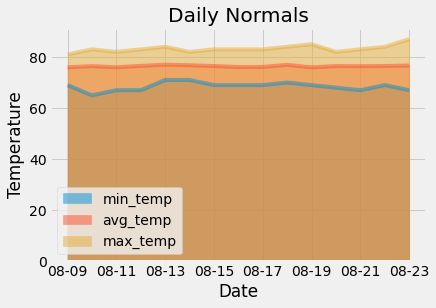

In [35]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked=False)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.title('Daily Normals')
plt.show()
